In [1]:
#imports
import os
import pandas as pd
import numpy as np
# import pickle as pk
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import ccxt
import time
from dotenv import load_dotenv
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.cryptocurrencies import CryptoCurrencies
import csv
import json
import joblib


Bad key "text.kerning_factor" on line 4 in
C:\Users\Josh Bond\Anaconda3\envs\dev\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
load_dotenv()

True

In [3]:
kraken_pub_key = os.getenv("KRAKEN_PUBLIC_KEY")
kraken_sec_key = os.getenv("KRAKEN_SECRET_KEY")
kraken = ccxt.kraken({"apiKey": kraken_pub_key, "secret": kraken_sec_key})

av_key = os.getenv("ALPHAVANTAGE_API_KEY")

In [4]:
# Getting BTC data and setting columns and date
btc_historical = kraken.fetch_ohlcv("BTC/USD", "1d")
btc_historical_df = pd.DataFrame(
    btc_historical, 
    columns=['date','open','high','low','close','volume']
)
btc_historical_df['date'] = pd.to_datetime(btc_historical_df['date'], unit='ms')
btc_historical_df = btc_historical_df.sort_values(by='date')

In [5]:
if not os.path.exists('./Data'):
    os.makedirs('./Data')
if not os.path.exists('./Models'):
    os.makedirs('./Models')
if not os.path.exists('./Results'):
    os.makedirs('./Results')

In [6]:
# Defining functions
def compute_ema(df, window, colname):
    df[colname] = df['close'].ewm(halflife=window).mean()
    return(df)


def compute_rsi(df, window, colname):
    series = df['close']
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    # first value is sum of avg gains
    u[u.index[window - 1]] = np.mean(u[:window])
    u = u.drop(u.index[:(window - 1)])
    # first value is sum of avg losses
    d[d.index[window - 1]] = np.mean(d[:window])
    d = d.drop(d.index[:(window - 1)])
    rs = u.ewm(com=window - 1,ignore_na=False,
               min_periods=0,adjust=False).mean() / d.ewm(com=window - 1, ignore_na=False,
                                            min_periods=0,adjust=False).mean()
    df[colname] = 100 - 100 / (1 + rs)
    df[colname].fillna(df[colname].mean(), inplace=True)
    return(df)


def jwwma(values, n):

    # J. Welles Wilder's EMA 
    
    return values.ewm(alpha=1/n, min_periods=n, adjust=False).mean()

    
def atr(df, n=14):
    # The range of a day's trading is high-low. 
    dataframe = df.copy()
    high = df['high']
    low = df['low']
    close = df['close']
    dataframe['tr_1'] = abs(high - low)
    dataframe['tr_2'] = abs(high - close.shift())
    dataframe['tr_3'] = abs(low - close.shift())
    # The average true range can be found by finding the 
    tr = dataframe[['tr_1', 'tr_2', 'tr_3']].max(axis=1)
    atr = jwwma(tr, n)
    return atr


def exit_trade():
    return exit_trade

In [7]:
def compute_variables1(df):
    print("Let's compute predictive variables : ")
    df["date"] = pd.to_datetime(df["date"])
    df['bodysize'] = df['close'] - df['open']
    df['shadowsize'] = df['high'] - df['low']
    for window in [3, 8, 21, 55, 144, 377]:
        print(window)
        df = compute_ema(df, window, colname = 'ema_{}'.format(window))
        df = compute_rsi(df, window, colname = 'rsi_{}'.format(window))
        df["Min_{}".format(window)] = df["low"].rolling(window).min()
        df["Max_{}".format(window)] = df["high"].rolling(window).max()
        df["volume_{}".format(window)] = df["volume"].rolling(window).mean()
        df['percentChange_{}'.format(window)] = df['close'].pct_change(periods = window)
        df['RelativeSize_ema_{}'.format(window)] = df['close'] / df['ema_{}'.format(window)]
        df['Diff_{}'.format(window)] = df['close'].diff(window)
    df['ATR(14)'] = atr(df, n=14)

    # (b) Add weekday and day of the month
    df["WeekDay"] = df["date"].dt.weekday
    df["Day"] = df["date"].dt.day
    df.dropna(inplace=True)
    return(df)

In [8]:
df = compute_variables1(btc_historical_df)

Let's compute predictive variables : 
3
8
21
55
144
377


In [9]:
df.to_csv('./Data/Datasetwithvariables.csv', index=False)

In [10]:
takeprofit = .12
stoploss = .05

In [11]:
def check_outcome(df, line, stoploss, takeprofit):
    '''0 means we reached stoploss
    1 means we reached takeprofit
    -1 means still in between'''
    price0 = df["close"].iloc[line]
    # atr = df["ATR(14)"].iloc[line]
    upper_lim = price0*(1+takeprofit)
    down_lim = price0*(1-stoploss)
    for i in range(line, df["close"].size):
        if df["low"].iloc[i] < down_lim :
            return(0)
        elif df["high"].iloc[i] > upper_lim :
            return(1)
    return(-1)

def compute_result(df, stoploss, takeprofit):
    df['result'] = 0
    for i in range(df["close"].size):
        if i%500 == 0:
            print(i, '/', df.shape[0])
        df['result'].iloc[i] = check_outcome(df, i, stoploss, takeprofit)
    return(df)

In [12]:
df = compute_result(df, stoploss, takeprofit)
df = df[df['result']>=0] # Only keep observations where we also have the result
df.to_csv('./Data/DatasetwithvariablesandY_SL{}_TP{}.csv'.format(stoploss, takeprofit), index = False)

0 / 343
C:\Users\Josh Bond\Anaconda3\envs\dev\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
df.head()

,date,open,high,low,close,volume,bodysize,shadowsize,ema_3,rsi_3,...,Min_377,Max_377,volume_377,percentChange_377,RelativeSize_ema_377,Diff_377,ATR(14),WeekDay,Day,result
377,2020-05-13,8818.1,9411.0,8808.1,9317.1,9472.110878,499.0,602.9,9047.985807,65.981404,...,3913.1,13875.7,6814.976539,0.728430,1.088703,3926.6,576.093673,2,13,0
378,2020-05-14,9317.1,9947.0,9256.9,9788.5,12966.020534,471.4,690.1,9200.753496,78.960749,...,3913.1,13875.7,6835.220766,0.729417,1.143185,4128.5,584.236982,3,14,0
379,2020-05-15,9788.5,9847.1,9128.0,9312.1,11082.915586,-476.4,719.1,9223.724221,50.026595,...,3913.1,13875.7,6852.059508,0.615702,1.087199,3548.6,593.870055,4,15,0
380,2020-05-16,9310.5,9590.0,9221.1,9386.0,4905.165281,75.5,368.9,9257.201629,53.952748,...,3913.1,13875.7,6860.725482,0.641110,1.095444,3666.7,577.800765,5,16,0
381,2020-05-17,9379.3,9888.0,9317.1,9673.0,6998.249638,293.7,570.9,9342.980614,68.410476,...,3913.1,13875.7,6872.643443,0.700777,1.128410,3985.6,577.307854,6,17,0


In [14]:
df['result'].value_counts()

0    198
1    143
Name: result, dtype: int64

In [15]:
# Define the trainset, validation set, testset
split1 = int(.65*len(df))

trainset = df[:split1]
val_test = df[split1:]

split2 = int(.5*len(val_test))

validation_set = val_test[:split2]
testset = val_test[split2:]

In [16]:
trainset.to_csv('./Data/Trainset_SL{}_TP{}.csv'.format(stoploss, takeprofit), index=False)
validation_set.to_csv('./Data/Validationset_SL{}_TP{}.csv'.format(stoploss, takeprofit), index=False)
testset.to_csv('./Data/Testset_SL{}_TP{}.csv'.format(stoploss, takeprofit), index=False)

C:\Users\Josh Bond\Anaconda3\envs\dev\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


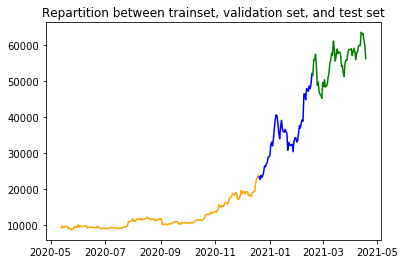

In [17]:
# Display the splitting
plt.plot(pd.to_datetime(trainset['date']), trainset['close'], c = 'orange')
plt.plot(pd.to_datetime(validation_set['date']), validation_set['close'], c = 'b')
plt.plot(pd.to_datetime(testset['date']), testset['close'], c = 'g')
plt.title('Repartition between trainset, validation set, and test set')
plt.show();

In [18]:
# (i) Scale the variables
scale_fct = StandardScaler()
scale_fct.fit(trainset.drop('date', 1).drop('result', 1))
joblib.dump(scale_fct, open('./Models/scaler.pkl','wb'))

In [19]:
# # (i) Scale the variables
# scale_fct = StandardScaler()
# scale_fct.fit(trainset.drop('date', 1).drop('result', 1))
# pk.dump(scale_fct, open('./Models/scaler.pkl','wb'))

In [20]:
# (ii) Apply PCA
pca = PCA(n_components=trainset.shape[1] - 2) # remove the result and the date
pca.fit(scale_fct.transform(trainset.drop('date', 1).drop('result', 1)))
joblib.dump(pca, open('./Models/pca.pkl', 'wb'))

In [21]:
# # (ii) Apply PCA
# pca = PCA(n_components=trainset.shape[1] - 2) # remove the result and the date
# pca.fit(scale_fct.transform(trainset.drop('date', 1).drop('result', 1)))
# pk.dump(pca, open('./Models/pca.pkl',"wb"))

In [22]:
# (iii) Scale PCA components (this accelerates training process in Deep Learning)
pca_scaler = StandardScaler()
pca_scaler.fit(pca.transform(scale_fct.transform(trainset.drop('date', 1).drop('result', 1))))
joblib.dump(pca_scaler, open('./Models/pca_scaler.pkl','wb'))

In [23]:
# # (iii) Scale PCA components (this accelerates training process in Deep Learning)
# pca_scaler = StandardScaler()
# pca_scaler.fit(pca.transform(scale_fct.transform(trainset.drop('date', 1).drop('result', 1))))
# pk.dump(pca_scaler, open('./Models/pca_scaler.pkl','wb'))

In [24]:
# (iv) Save ready-to-use versions (i.e. datasets after applying scalers and PCA)
trainset_final = pd.DataFrame(pca_scaler.transform(pca.transform(scale_fct.transform(trainset.drop('date', 1).drop('result', 1)))))
validation_set_final = pd.DataFrame(pca_scaler.transform(pca.transform(scale_fct.transform(validation_set.drop('date', 1).drop('result', 1)))))
testset_final = pd.DataFrame(pca_scaler.transform(pca.transform(scale_fct.transform(testset.drop('date', 1).drop('result', 1)))))

In [25]:
trainset_final.to_csv('./Data/Trainset_final_SL{}_TP{}.csv'.format(stoploss, takeprofit), index = False)
validation_set_final.to_csv('./Data/Validationset_final_SL{}_TP{}.csv'.format(stoploss, takeprofit), index = False)
testset_final.to_csv('./Data/Testset_final_SL{}_TP{}.csv'.format(stoploss, takeprofit), index = False)